# Segmentation of Indian Traffic

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Tue Mar 29 12:47:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib

<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [ ]:
!unzip '/content/drive/MyDrive/Datasets/data.zip' -d '/content/'

In [ ]:
def return_file_names_df(root_dir):
    # This snippet will create a dataframe with two columns ['images', 'json']
    # The column 'images' will have path to images
    # The column 'json' will have path to json files
    all_images_path = []
    all_masks_path  = []

    image_path = root_dir + 'images'
    mask_path  = root_dir + 'mask'

    for filename, dirs, files in os.walk(image_path):
        if files != []:
            for image in sorted(files):
                all_images_path.append((filename + '/' + image))
    
    for filename, dirs, files in os.walk(mask_path):
        if files != []:
            for json in sorted(files):
                all_masks_path.append((filename + '/'+ json))
    
    data_df = pd.DataFrame({'images' : all_images_path, 'json' : all_masks_path})
    
    return data_df

In [ ]:
root_dir = '/content/data/'
data_df = return_file_names_df(root_dir)
data_df.head()

images  \
0  /content/data/images/233/frame0299_leftImg8bit...   
1  /content/data/images/233/frame0702_leftImg8bit...   
2  /content/data/images/233/frame1002_leftImg8bit...   
3  /content/data/images/322/frame0010_leftImg8bit...   
4  /content/data/images/322/frame0149_leftImg8bit...   

                                                json  
0  /content/data/mask/233/frame0299_gtFine_polygo...  
1  /content/data/mask/233/frame0702_gtFine_polygo...  
2  /content/data/mask/233/frame1002_gtFine_polygo...  
3  /content/data/mask/322/frame0010_gtFine_polygo...  
4  /content/data/mask/322/frame0149_gtFine_polygo...

> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [ ]:
def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

<pre>
Small change in grader_1 function beacuse my root address for colab was longer than default grader_1
default:              i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')])
Updated for colab:    i[0][20:i[0].find('_')]==i[1][18:i[1].find('_')])
</pre>

In [ ]:
def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][20:i[0].find('_')]==i[1][18:i[1].find('_')]):
            return False
    return True

In [ ]:
grader_1(data_df)

True

In [ ]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [ ]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    labels = []
    
    for files in data_df.json:
        file = open(files)
        json_file = json.load(file)
        
        for object in json_file['objects']:
            labels.append(object['label'])
        file.close()    
    unique_labels = set(labels) # only unique lables
    return unique_labels

In [ ]:
unique_labels = return_unique_labels(data_df)

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [ ]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, 
  that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array/10.
</pre>

## 3. Extracting the polygons from the json files

In [ ]:
def get_poly(file):
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location

    # width of the image
    # height of the image

    label = []
    vertexlist = []
    fi = open(file)
    json_file = json.load(fi)
    
    for object in json_file['objects']:
        label.append(object['label'])                  # list of labels for all the objects
        tuple_1 = [tuple(x) for x in object['polygon']]
        vertexlist.append(tuple_1)                      # list of list of vertices in tuple formate
        
    w = json_file['imgWidth']                          # width of the image
    h = json_file['imgHeight']                         # height of the image
    fi.close()

    return w, h, label, vertexlist

In [ ]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

### Example

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

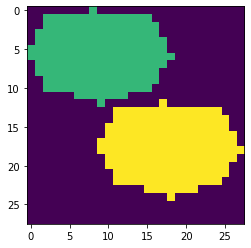

In [ ]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [ ]:
def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygone in image like this
    
    # img = Image.new("RGB", (w, h))
    # img1 = ImageDraw.Draw(img)
    # img1.polygon(vertexlist[i], fill = label_clr[label[i]])
    
    # after drawing all the polygons that we collected from json file, 
    # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths

    mask_paths = []
    for json_file in tqdm(data_df['json']):
        
        w, h, labels, vertexlist = get_poly(json_file)  # obtain w,h,vertices and labels 
        img_1  = Image.new("RGB", (w, h))
        img_2 = ImageDraw.Draw(img_1)
        
        for i in range(len(vertexlist)):                # adding co-ordinates of each label
            if (len(vertexlist[i]) > 1 ):                                  
                img_2.polygon(vertexlist[i], fill = label_clr[labels[i]])
                    
        img_1 = np.array(img_1)
        img  = Image.fromarray(img_1[:,:,0])
        
        path = json_file[:22]                           # obtain name of json file (first 22 characters)                           
        path = path.replace('mask','output')            # create '/content/data/output/' folder by modifying the json file name
        if os.path.exists(path)==False:                 # create folder if not created already
            os.makedirs(path)

        save_this_path = path + '/' + json_file.split('/')[5].split('.')[0] + '.png' 
        img.save(save_this_path)
        mask_paths.append(save_this_path)               # save the path as element to a list
    data_df['mask'] = mask_paths                        # create mask column in data_df and add the mask_path

    return data_df

In [ ]:
data_df = compute_masks(data_df)
data_df.head()

100%|██████████| 4008/4008 [04:10<00:00, 16.01it/s]


images  \
0  /content/data/images/233/frame0299_leftImg8bit...   
1  /content/data/images/233/frame0702_leftImg8bit...   
2  /content/data/images/233/frame1002_leftImg8bit...   
3  /content/data/images/322/frame0010_leftImg8bit...   
4  /content/data/images/322/frame0149_leftImg8bit...   

                                                json  \
0  /content/data/mask/233/frame0299_gtFine_polygo...   
1  /content/data/mask/233/frame0702_gtFine_polygo...   
2  /content/data/mask/233/frame1002_gtFine_polygo...   
3  /content/data/mask/322/frame0010_gtFine_polygo...   
4  /content/data/mask/322/frame0149_gtFine_polygo...   

                                                mask  
0  /content/data/output/233/frame0299_gtFine_poly...  
1  /content/data/output/233/frame0702_gtFine_poly...  
2  /content/data/output/233/frame1002_gtFine_poly...  
3  /content/data/output/322/frame0010_gtFine_poly...  
4  /content/data/output/322/frame0149_gtFine_poly...

In [ ]:
# daving the final dataframe to a csv file
data_df.to_csv('preprocessed_data.csv', index=False)

# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

In [1]:
!pip install segmentation-models

     |████████████████████████████████| 50 kB 4.8 MB/s 


In [3]:
import tensorflow as tf
from tensorflow import keras
# tf.compat.v1.enable_eager_execution()

import segmentation_models as sm
sm.set_framework('tf.keras')
from segmentation_models import Unet
import imgaug.augmenters as iaa
from segmentation_models.metrics import iou_score
from sklearn.model_selection import train_test_split

### Task 2.1: Dice loss

<pre>
* Explain the Dice loss
* 1. Write the formualtion
* 2. Range of the loss function
* 3. Interpretation of loss function
* 4. Write your understanding of the loss function, how does it helps in segmentation
</pre>

Ref : https://www.jeremyjordan.me/semantic-segmentation/#loss
<pre>
Dice Coefficient (D.C.) measures the overlapping between ground truth and predicted output.
From the perspective of set theory, if X and Y are two sets, it can be represented as:
D.C = 2*(X intersection Y) / X + Y

In the case of an image, we can approximate X intersecting Y as the element-wise multiplication between the prediction and target mask, then sum the resulting matrix. X and Y can be calculated using the simple sum, but other researchers prefer to use the squared sum.

The overlap between the ground truth and predicted value will be higher when they are more similar, and the dice coefficient will be larger as a result. Its minimum value is 0 when there is no overlap and its maximum value is 1. In order to maximize the amount of overlap, we have to maximize the dice coefficient. The Dice loss can be represented as 1 - a dice coefficient, in order to create a loss function we should minimize. Therefore, the dice loss also ranges from 0 to 1.

With an image as in our case, the numerator considers the overlap between the two sets of boundary pixels at the local scale, while the denominator considers the total number of pixels at the global scale. So, it can be said that the dice loss considers the loss of information both locally and globally.
</pre>

### Task 2.2: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.
</pre>

In [ ]:
X_train, X_test = train_test_split(data_df, test_size=0.2, random_state=46)

X_train.reset_index(inplace = True, drop = True)
X_test.reset_index(inplace = True, drop = True)

In [4]:
model_1 = Unet('resnet34',
             encoder_weights='imagenet',
             classes=21,
             activation='softmax',
             encoder_freeze = True,
             input_shape=(512,512,3))
model_1.summary()

85532672/85521592 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 512, 512, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)            

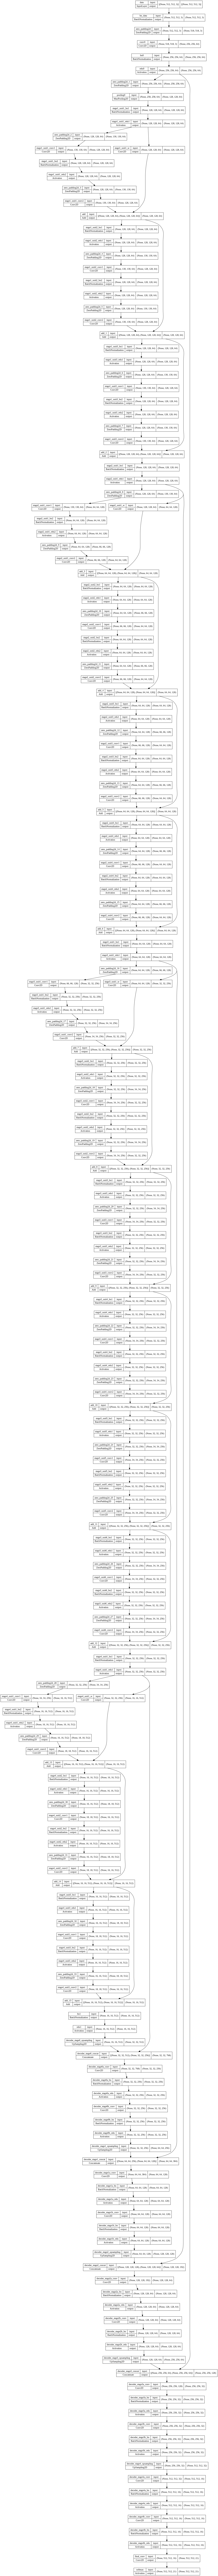

In [5]:
tf.keras.utils.plot_model(model_1, to_file='model_1.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [ ]:
# Adding 4 tecniques for Image augmentation
aug1 = iaa.Fliplr(1)
aug2 = iaa.Emboss(alpha=(1), strength=1)
aug3 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug4 = iaa.PerspectiveTransform(scale=(0.01, 0.15))

In [ ]:
# code taken from "Reference_Piplines" notebook
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()


class Dataset:
    
    def __init__(self, image_file_names, mask_file_names, classes):
        
        self.image_ids = image_file_names
        self.mask_ids  = mask_file_names
        
        # the paths of images
        self.images_fps   = [image_id for image_id in self.image_ids]
        # the paths of segmentation images
        self.masks_fps    = [mask_id for mask_id in self.mask_ids]
        # giving labels for each class
        self.class_values = classes

    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image,(512,512),interpolation=cv2.INTER_NEAREST)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
         
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        image_mask = cv2.resize(mask,(512,512))
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        if (self.images_fps[i] in X_train):
        
            a = np.random.uniform()
            if a<0.25:
                image      = aug1.augment_image(image)
                image_mask = aug1.augment_image(image_mask)
            elif a<0.50:
                image      = aug2.augment_image(image)
                image_mask = aug2.augment_image(image_mask)
            elif a<0.75:
                image      = aug3.augment_image(image)
                image_mask = aug3.augment_image(image_mask)
            else:
                image      = aug4.augment_image(image)
                image_mask = aug4.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.image_ids)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
# Dataset for train images
CLASSES = list(np.unique(list(label_clr.values())))

train_dataset = Dataset(X_train['images'].values,X_train['mask'].values, classes=CLASSES)
test_dataset  = Dataset(X_test['images'].values, X_test['mask'].values, classes=CLASSES)

BATCH_SIZE = 2
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

(2, 512, 512, 3)
(2, 512, 512, 21)


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
from keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau
import datetime

# define callbacks for learning rate scheduling and best checkpoints saving
checkpoint  =  ModelCheckpoint('/content/best_model.h5', save_weights_only=True, save_best_only=True, monitor='val_iou_score')

# Reduce_LR = ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2)

# TENSORBOARD callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# we use the same loss metric as used in the reference notebook
# from the documentation , cce_dice_loss is catgorical cross entropy + dice loss
focal_loss = sm.losses.cce_dice_loss

In [ ]:
model_1.compile(optimizer, focal_loss, metrics=[iou_score])

In [ ]:
history = model_1.fit(train_dataloader,
                    steps_per_epoch=len(train_dataloader),
                    epochs=7,
                    validation_data=test_dataloader,
                    callbacks=[checkpoint, tensorboard_callback] )

Epoch 1/7
1603/1603 [==============================] - 770s 462ms/step - loss: 0.7472 - iou_score: 0.2334 - val_loss: 0.6771 - val_iou_score: 0.2883
Epoch 2/7
1603/1603 [==============================] - 737s 460ms/step - loss: 0.6610 - iou_score: 0.3013 - val_loss: 0.6389 - val_iou_score: 0.3191
Epoch 3/7
1603/1603 [==============================] - 735s 458ms/step - loss: 0.6129 - iou_score: 0.3463 - val_loss: 0.4939 - val_iou_score: 0.4621
Epoch 4/7
1603/1603 [==============================] - 734s 458ms/step - loss: 0.4760 - iou_score: 0.4806 - val_loss: 0.4842 - val_iou_score: 0.4741
Epoch 5/7
1603/1603 [==============================] - 736s 459ms/step - loss: 0.4637 - iou_score: 0.4913 - val_loss: 0.4715 - val_iou_score: 0.4857
Epoch 6/7
1603/1603 [==============================] - 735s 458ms/step - loss: 0.4522 - iou_score: 0.5016 - val_loss: 0.4709 - val_iou_score: 0.4862
Epoch 7/7
1603/1603 [==============================] - 734s 458ms/step - loss: 0.4438 - iou_score: 0.5089 

In [5]:
best_ioc_score_m1, best_dice_loss_m1 = 0.4951, 0.4745

In [ ]:
X_test_sample = X_test.sample(n=20)    ## taking 20 random samples from X_test
X_test_sample = X_test_sample.reset_index()
sample_image  = X_test_sample['images'].values
sample_mask   = X_test_sample['mask'].values

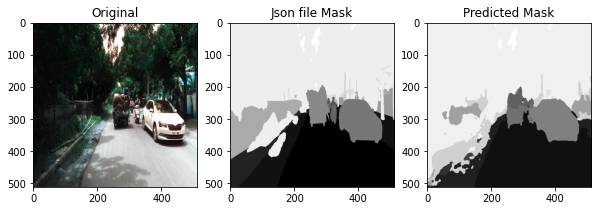

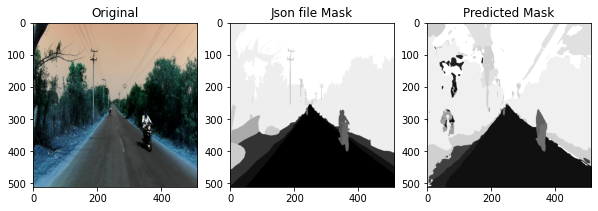

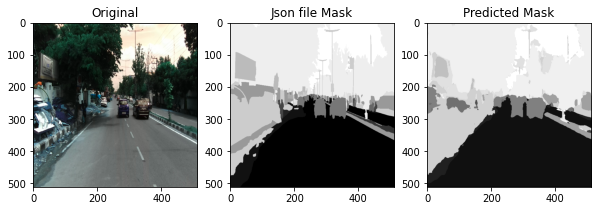

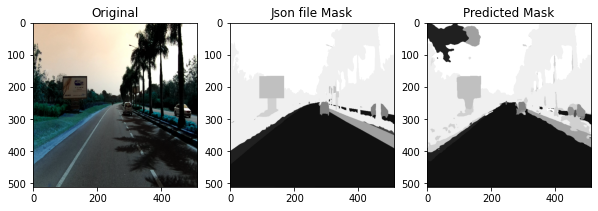

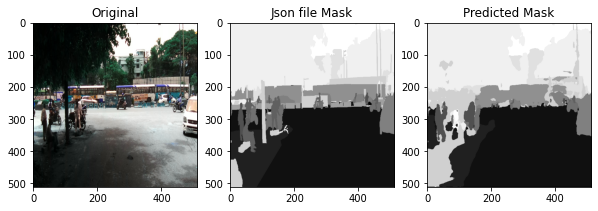

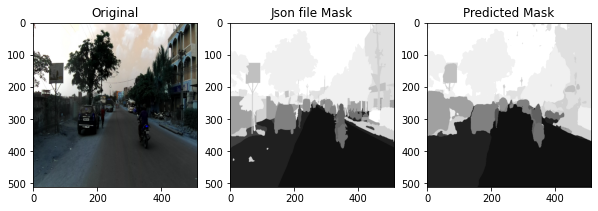

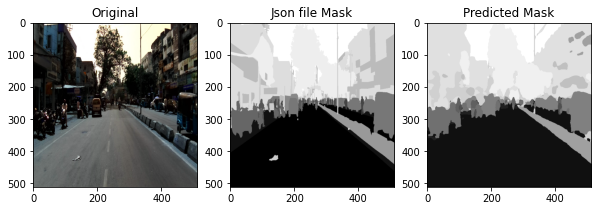

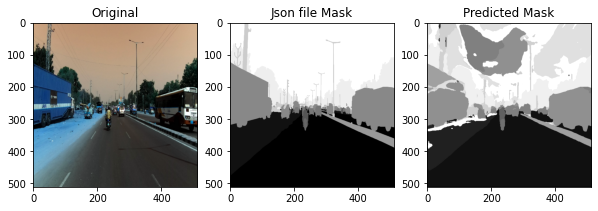

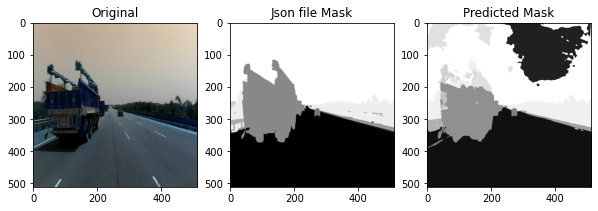

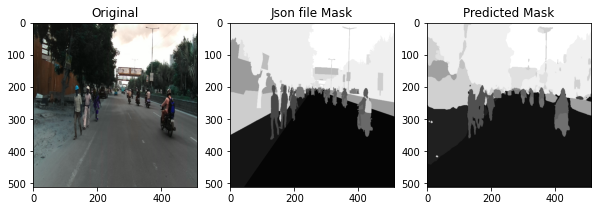

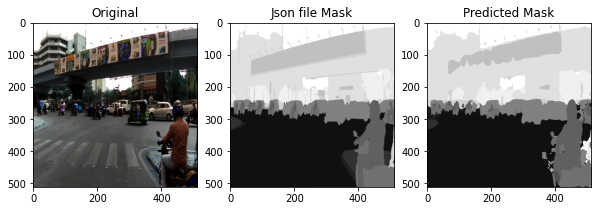

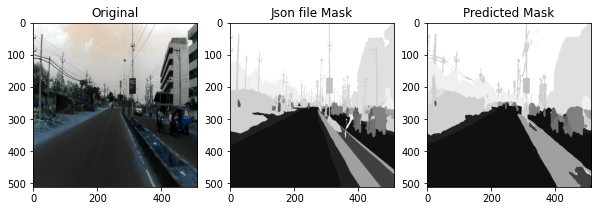

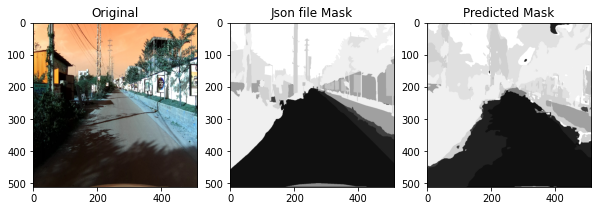

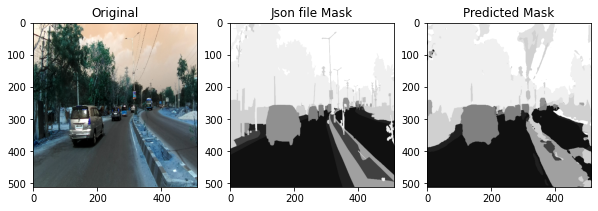

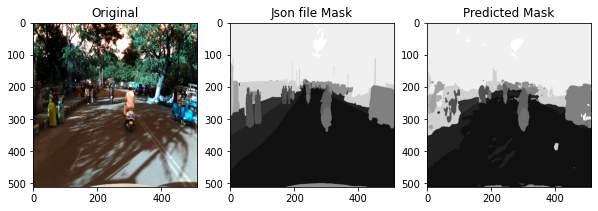

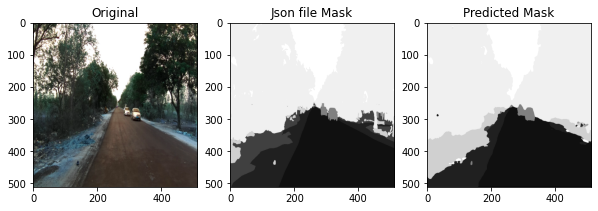

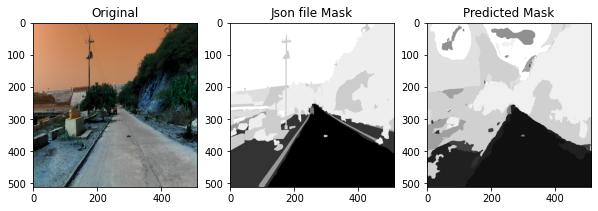

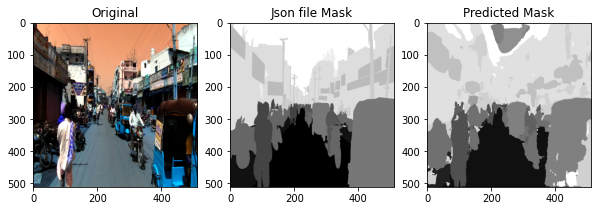

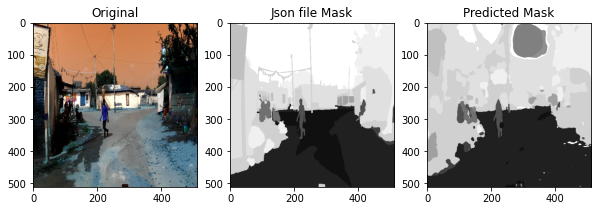

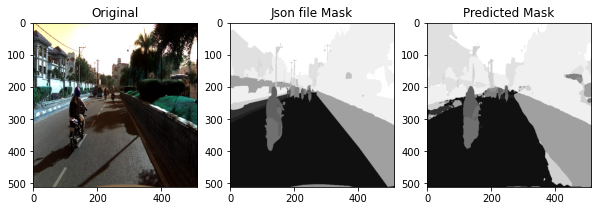

In [ ]:
for i in range(20):
    
    #original image
    image = cv2.imread(sample_image[i], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (512,512),interpolation = cv2.INTER_NEAREST) 
    
    #predicted segmentation mask
    predicted = model_1.predict(image[np.newaxis,:,:,:])
    predicted = tf.argmax(predicted, axis=-1)

    #original segmentation map
    image_mask = cv2.imread(sample_mask[i] , cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (512,512))

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.title('Original')

    plt.subplot(132)
    plt.imshow(image_mask,cmap='gray')
    plt.title('Json file Mask')

    plt.subplot(133)
    plt.imshow(predicted[0,:,:], cmap='gray')
    plt.title('Predicted Mask')

    plt.show()

In [ ]:
%tensorboard --logdir logs/fit

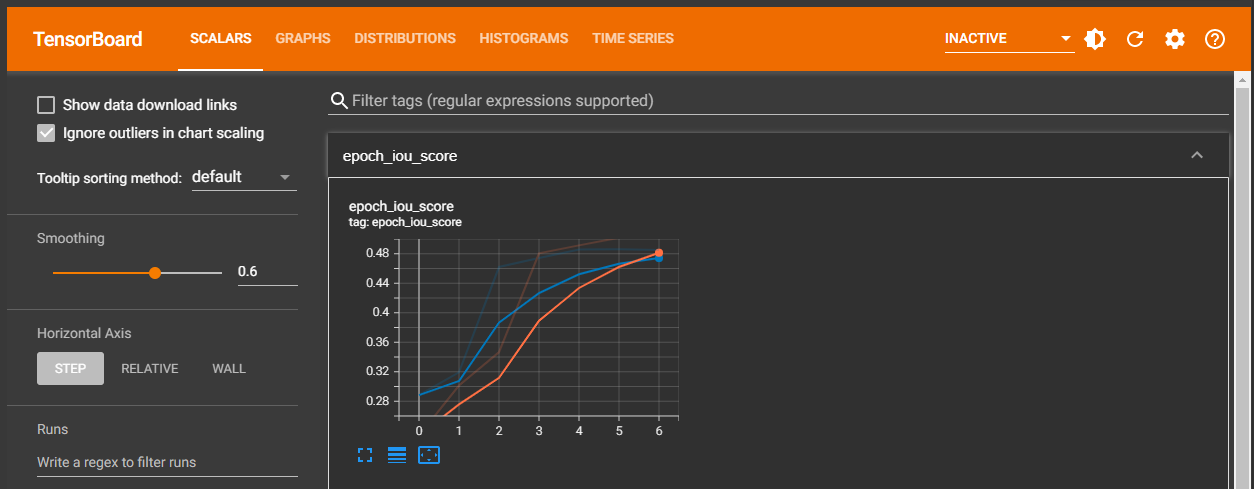

# Task 3: Training CANet

In [ ]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

* as a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [7]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self,  filters, stride, name="conv block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.stride = stride

        self.conv_layer_1 = Conv2D(self.F1,
                                    activation='relu',
                                    kernel_size=(1,1))

        self.conv_layer_2 = Conv2D(self.F2,
                                    activation='relu',
                                    kernel_size=(3,3),
                                    strides=(self.stride,self.stride),
                                    padding='same')
        
        self.conv_layer_3 = Conv2D(self.F3,
                                    activation='relu',
                                    kernel_size=(1,1))
        
        self.conv_layer_4 = Conv2D(self.F3,
                                    activation='relu',
                                    kernel_size=(3,3),
                                    strides=(self.stride,self.stride),
                                    padding='same')
        
        self.bn_layer_1 = BatchNormalization()
        self.bn_layer_2 = BatchNormalization()
        self.bn_layer_3 = BatchNormalization()
        self.bn_layer_4 = BatchNormalization()

        self.activ = Activation('relu')
        self.add = Add()


    def call(self, X):
        # write the architecutre that was mentioned above
        conv_lr_1 = self.conv_layer_1(X)
        bn_lr_1 = self.bn_layer_1(conv_lr_1)
        activ_lr_1 = self.activ(bn_lr_1)
        conv_lr_2 = self.conv_layer_2(activ_lr_1)
        bn_lr_2 = self.bn_layer_2(conv_lr_2)
        activ_lr_2 = self.activ(bn_lr_2)
        conv_lr_3 = self.conv_layer_3(activ_lr_2)
        bn_lr_3 = self.bn_layer_3(conv_lr_3)
        
        ##parallel layer
        conv_lr_4 = self.conv_layer_4(X)
        bn_lr_4 = self.bn_layer_4(conv_lr_4)
        activ_lr_3 = self.activ(bn_lr_4)
        add_1 = self.add([bn_lr_3, activ_lr_3])
        X = self.activ(add_1)
        
        return X

In [16]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self,  filters, name="identity block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters

        self.conv_layer_1 = Conv2D(self.F1,
                                    activation='relu',
                                    kernel_size=(1,1))
        
        self.conv_layer_2 = Conv2D(self.F2,
                                    activation='relu',
                                    kernel_size=(3,3),
                                    padding='same')
        
        self.conv_layer_3 = Conv2D(self.F3,
                                   activation='relu',
                                   kernel_size=(1,1))
        
        self.bn_layer_1 = BatchNormalization()
        self.bn_layer_2 = BatchNormalization()
        self.bn_layer_3 = BatchNormalization()

        self.activ = Activation('relu')
        self.add = Add()
    
    def call(self, X):
        # write the architecutre that was mentioned above
        conv_lr_1 = self.conv_layer_1(X)
        bn_lr_1 = self.bn_layer_1(conv_lr_1)
        activ_lr_1 = self.activ(bn_lr_1)
        conv_lr_2 = self.conv_layer_2(activ_lr_1)
        bn_lr_2 = self.bn_layer_2(conv_lr_2)
        activ_lr_2 = self.activ(bn_lr_2)
        conv_lr_3 = self.conv_layer_3(activ_lr_2)
        bn_lr_3 = self.bn_layer_3(conv_lr_3)
        add = self.add((X, bn_lr_3))
        X = self.activ(add)
        return X

* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [9]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, name="global_flow"):
        super().__init__(name=name)
        
        self.bn_layer = BatchNormalization()
        self.activ = Activation('relu')
        self.conv_layer = Conv2D(64,
                                 activation='relu',
                                 kernel_size=(1,1),
                                 padding='same')
        
        self.up_sampling = UpSampling2D(size=(64,64), interpolation='bilinear') 
        self.global_avg_pool = GlobalAveragePooling2D()
        
    def call(self, X):
        # implement the global flow operatiom
        global_avgpool_lr = self.global_avg_pool(X)
        global_avgpool_lr = tf.expand_dims(global_avgpool_lr, 1)
        global_avgpool_lr = tf.expand_dims(global_avgpool_lr, 1)
        bn_lr  = self.bn_layer(global_avgpool_lr)
        activ_lr = self.activ(bn_lr)
        conv_lr = self.conv_layer(activ_lr)
        X = self.up_sampling(conv_lr)
        
        return X

In [10]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(name=name)

        self.concat_layer = Concatenate()
        self.avgpool_layer = AveragePooling2D(pool_size=(2, 2))
        self.add = Add()
        self.multiply = Multiply()
        self.bn_layer= BatchNormalization()

        self.conv3x3_layer_1 = Conv2D(64, activation='relu',
                                       kernel_size=(3,3),
                                       padding='same')
        
        self.conv3x3_layer_2 = Conv2D(64, activation='relu',
                                       kernel_size=(3,3),
                                       padding='same')
        
        self.conv1x1_layer_1 = Conv2D(64, activation='relu',
                                      kernel_size=(1,1),
                                      padding='same')
        
        self.conv1x1_layer_2 = Conv2D(64, activation='relu',
                                      kernel_size=(1,1),
                                      padding='same')
        
        self.activ_relu = Activation('relu')
        self.activ_sigmoid = Activation('sigmoid')
        self.up_sampling = UpSampling2D(size=(2,2), interpolation='bilinear') 
        
    def call(self, X):
        # here X will a list of two elements
        INP, FLOW = X[0], X[1]
        # implement the context flow as mentioned in the above cell

        concat_lr = self.concat_layer([INP, FLOW])
        avg_pool_lr = self.avgpool_layer(concat_lr)
        conv_lr_1 = self.conv3x3_layer_1(avg_pool_lr)
        conv_lr_2 = self.conv3x3_layer_2(conv_lr_1)
        conv_lr_3 = self.conv1x1_layer_1(conv_lr_2)
        relu_activ = self.activ_relu(conv_lr_3)
        conv_lr_4 = self.conv1x1_layer_2(relu_activ)
        bn_lr = self.bn_layer(conv_lr_4)
        sigmoid_activ = self.activ_sigmoid(bn_lr)
        
        multi = self.multiply([sigmoid_activ, conv_lr_2])
        add = self.add([multi, conv_lr_2])                        
        X = self.up_sampling(add)
        
        return X

* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [11]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)

        self.conv3x3_layer_1 = Conv2D(32,activation='relu', kernel_size=(3,3),padding='same')
        self.conv1x1_layer_1 = Conv2D(32,activation='relu', kernel_size=(1,1),padding='same')
        self.global_pool = GlobalAveragePooling2D()
        self.bn_layer = BatchNormalization()
        self.sigmoid_activ = Activation('sigmoid')  
        self.multiply = Multiply()
        self.up_sampling = UpSampling2D(size=(2,2),interpolation='bilinear')
        
    def call(self, X):
        # implement the FSM modules based on image in the above cells
        conv_lr_1 = self.conv3x3_layer_1(X)
        global_pool_lr = self.global_pool(conv_lr_1)
        global_pool_lr = tf.expand_dims(global_pool_lr, 1)
        global_pool_lr = tf.expand_dims(global_pool_lr, 1)        
        conv_lr_2 = self.conv1x1_layer_1(global_pool_lr)
        bn_lr = self.bn_layer(conv_lr_2)
        activ_lr = self.sigmoid_activ(bn_lr)
        output = self.multiply([conv_lr_1, activ_lr])
        FSM_Conv_T = self.up_sampling(output)
        
        return FSM_Conv_T

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [12]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)
        self.conv_layer_1  = Conv2D(32,activation='relu',kernel_size=(7,1),padding='same')
        self.conv_layer_2  = Conv2D(32,activation='relu',kernel_size=(1,7),padding='same')
        self.conv_layer_3  = Conv2D(32,activation='relu',kernel_size=(7,1),padding='same')
        self.conv_layer_4  = Conv2D(32,activation='relu',kernel_size=(1,7),padding='same')
        self.conv_layer_5  = Conv2D(32,activation='relu',kernel_size=(3,3),padding='same')
        self.add = Add()
        
    def call(self, X):
        # please implement the above mentioned architecture
        conv_lr_1 = self.conv_layer_1(X)
        conv_lr_2 = self.conv_layer_2(conv_lr_1)
        conv_lr_3 = self.conv_layer_3(X)
        conv_lr_4 = self.conv_layer_4(conv_lr_3)
        add = self.add([conv_lr_2,conv_lr_4])
        conv_lr_5 = self.conv_layer_5(add)
        X = self.add([conv_lr_5, add])
        
        return X

*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

In [17]:
X_input = Input(shape=(512, 512, 3))
print('Input shape: ', X_input.shape)

# Stage 1
L = Conv2D(64, (3, 3),
           name='conv1',
           padding="same",
           kernel_initializer=glorot_uniform(seed=0))(X_input)

L = BatchNormalization(axis=3, name='bn_conv1')(L)
L = Activation('relu')(L)
L = MaxPooling2D((2, 2), strides=(2, 2))(L)

# C1 
L = convolutional_block(filters=[4,4,8],
                        stride=2,
                        name="conv_block_1")(L)
L = identity_block(filters=[4,4,8],
                   name='identity_block_1')(L)
L_C1 = L

L = convolutional_block(filters=[8,8,16],
                        stride=2,
                        name="conv_block_2")(L)
L = identity_block(filters=[8,8,16],
                   name='identity_block_21')(L)
L = identity_block(filters=[8,8,16],
                   name='identity_block_22')(L)

L = convolutional_block(filters=[16,16,32],
                        stride=1,
                        name="conv_block_3")(L)
L = identity_block(filters=[16,16,32],
                   name='identity_block_31')(L)
L = identity_block(filters=[16,16,32],
                   name='identity_block_32')(L)
L = identity_block(filters=[16,16,32],
                   name='identity_block_33')(L)

L = convolutional_block(filters=[32,32,64],
                        stride=1,
                        name="conv_block_4")(L)
L = identity_block(filters=[32,32,64],
                   name='identity_block_41')(L)
L = identity_block(filters=[32,32,64],
                   name='identity_block_42')(L)
L = identity_block(filters=[32,32,64],
                   name='identity_block_43')(L)
L = identity_block(filters=[32,32,64],
                   name='identity_block_44')(L)

L_GF  = global_flow(name = 'global_flow')(L)
L_CF1 = context_flow(name='context_flow_1')([L, L_GF])
L_CF2 = context_flow(name='context_flow_2')([L, L_CF1])
L_CF3 = context_flow(name='context_flow_3')([L, L_CF2])
add = Add()([L_GF, L_CF1, L_CF2, L_CF3])

L_FSM = fsm(name="feature_selection")(add)
L_AGCN = agcn(name="global_conv_net")(L_C1)

concat = Concatenate()([L_AGCN, L_FSM])

L_conv = Conv2D(21,kernel_size=(3,3),activation='relu',padding='same')(concat)
L_up = UpSampling2D((4,4), interpolation = 'bilinear')(L_conv)
output = Activation('softmax')(L_up)

print('Output shape: ',output.shape)

Input shape:  (None, 512, 512, 3)
Output shape:  (None, 512, 512, 21)


* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

In [18]:
# write the complete architecutre
model_2 = Model(inputs = X_input, outputs = output)

model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 512, 512, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 512, 512, 64  256         ['conv1[0][0]']                  
                                )                                                           

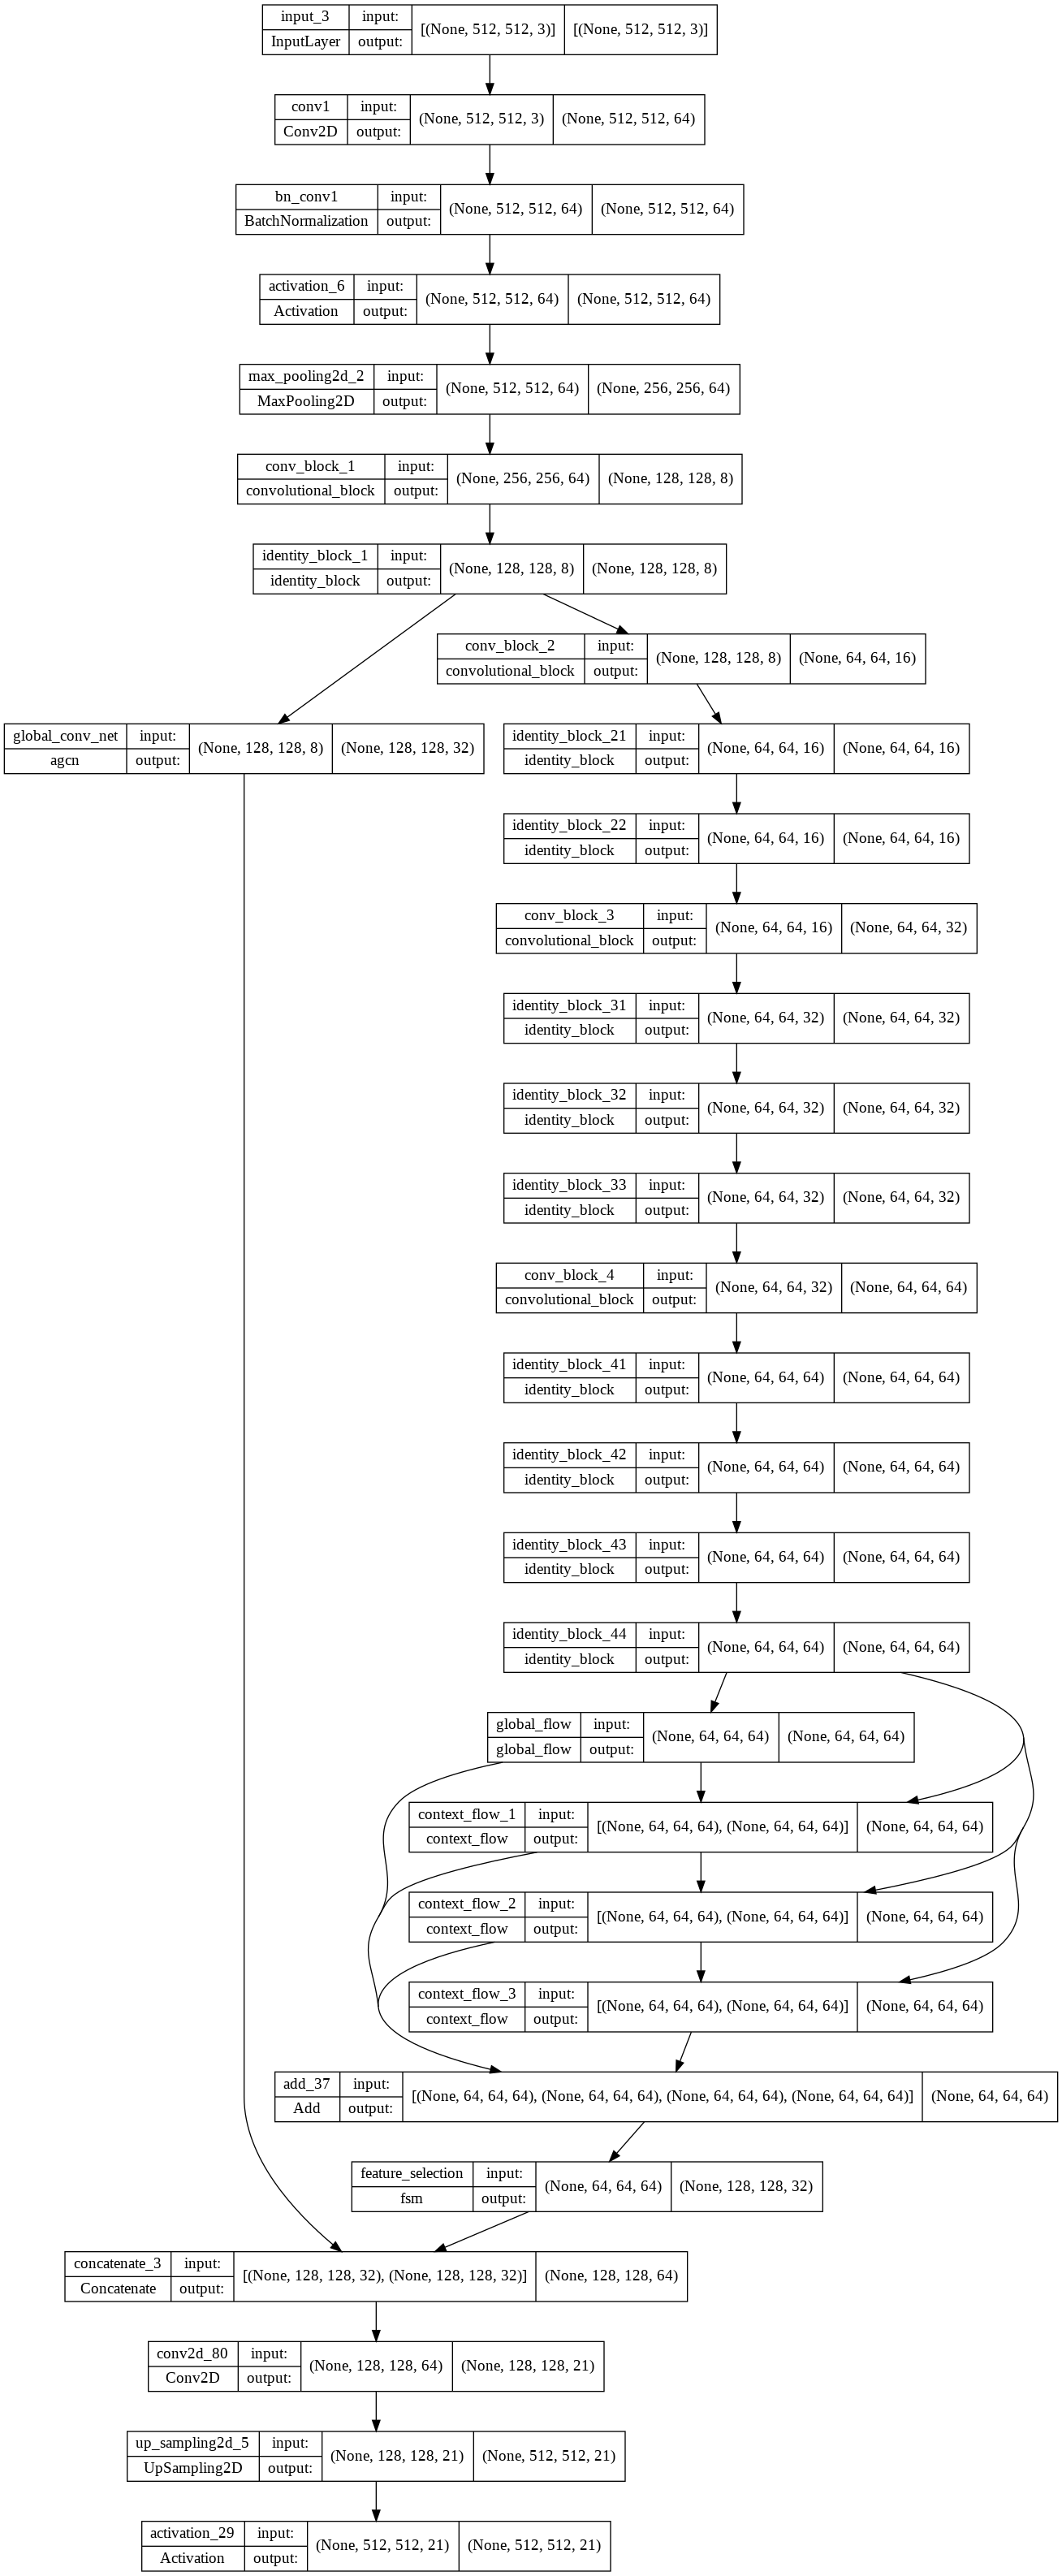

In [19]:
tf.keras.utils.plot_model(model_2, to_file='model_2.png', show_shapes=True, show_layer_names=True,rankdir='TB')

### Usefull tips:
* use "interpolation=cv2.INTER_NEAREST" when you are resizing the image, so that it won't mess with the number of classes
* keep the images in the square shape like $256*256$ or $512*512$
* Carefull when you are converting the (W, H) output image into (W, H, Classes)
* Even for the canet, use the segmentation model's losses and the metrics
* The goal of this assignment is make you familier in with computer vision problems, image preprocessing, building complex architectures and implementing research papers, so that in future you will be very confident in industry
* you can use the tensorboard logss to see how is yours model's training happening
* use callbacks that you have implemented in previous assignments

In [ ]:
# adding 4 image augmentations techniques
aug1 = iaa.Fliplr(1)
aug2 = iaa.Emboss(alpha=(1), strength=1)
aug3 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug4 = iaa.PerspectiveTransform(scale=(0.01, 0.15))

In [ ]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()
    
class Dataset:
    
    def __init__(self, image_file_names, mask_file_names, classes):
        
        self.image_ids = image_file_names
        self.mask_ids  = mask_file_names
        
        # the paths of images
        self.images_fps   = [image_id for image_id in self.image_ids]
        # the paths of segmentation images
        self.masks_fps    = [mask_id for mask_id in self.mask_ids]
        # giving labels for each class
        self.class_values = classes                                         
   
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image,(512,512),interpolation=cv2.INTER_NEAREST)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        image_mask = cv2.resize(mask,(512,512))
         
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        if (self.images_fps[i] in X_train):
            a = np.random.uniform()
            if a<0.25:
                image      = aug1.augment_image(image)
                image_mask = aug1.augment_image(image_mask)
            elif a<0.50:
                image      = aug2.augment_image(image)
                image_mask = aug2.augment_image(image_mask)
            elif a<0.75:
                image      = aug3.augment_image(image)
                image_mask = aug3.augment_image(image_mask)
            else:
                image      = aug4.augment_image(image)
                image_mask = aug4.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.image_ids)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
# Dataset for train images
CLASSES = list(np.unique(list(label_clr.values())))

train_dataset = Dataset(X_train['images'].values,X_train['mask'].values, classes=CLASSES)
test_dataset  = Dataset(X_test['images'].values, X_test['mask'].values, classes=CLASSES)

BATCH_SIZE = 2
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

(2, 512, 512, 3)
(2, 512, 512, 21)


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
from keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau
import datetime

# define callbacks for learning rate scheduling and best checkpoints saving
checkpoint  =  ModelCheckpoint('/content/best_model_2.h5', save_weights_only=True, save_best_only=True, monitor='val_iou_score')

Reduce_LR = ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2)

# TENSORBOARD callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# we use the same loss metric as used in the reference notebook
# from the documentation , cce_dice_loss is catgorical cross entropy + dice loss
focal_loss = sm.losses.cce_dice_loss

In [ ]:
model_2.compile(optimizer, focal_loss, metrics=[iou_score])

In [ ]:
history_2 = model_2.fit(train_dataloader,
                        steps_per_epoch=len(train_dataloader),
                        epochs=60,
                        validation_data=test_dataloader,
                        callbacks=[checkpoint, Reduce_LR, tensorboard_callback] )

Layer identity_block has arguments ['self', 'filters']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/30
1603/1603 [==============================] - 351s 215ms/step - loss: 0.8237 - iou_score: 0.1802 - val_loss: 0.8192 - val_iou_score: 0.1795
Epoch 2/30
1603/1603 [==============================] - 342s 213ms/step - loss: 0.7909 - iou_score: 0.2021 - val_loss: 0.9008 - val_iou_score: 0.1492
Epoch 3/30
1603/1603 [==============================] - 337s 210ms/step - loss: 0.7792 - iou_score: 0.2105 - val_loss: 0.8071 - val_iou_score: 0.1954
Epoch 4/30
1603/1603 [==============================] - 336s 210ms/step - loss: 0.7774 - i

In [2]:
best_ioc_score_m2, best_dice_loss_m2 = 0.3980, 0.7325

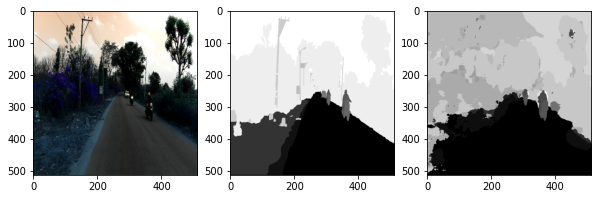

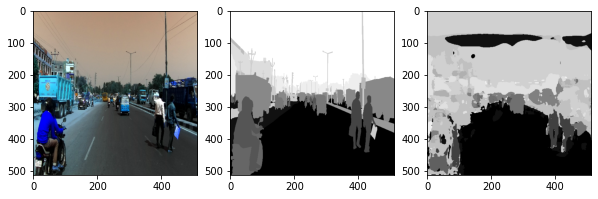

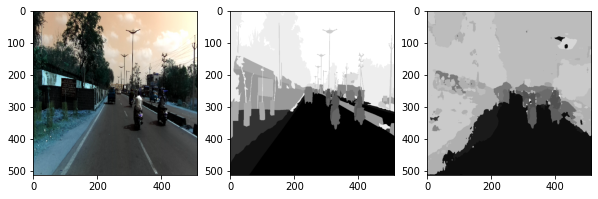

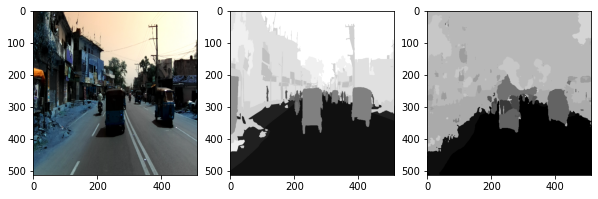

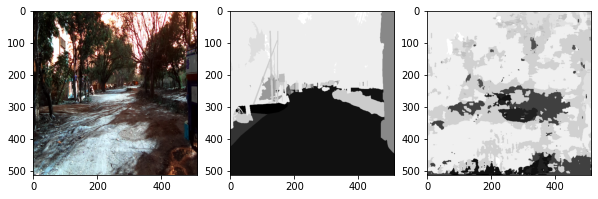

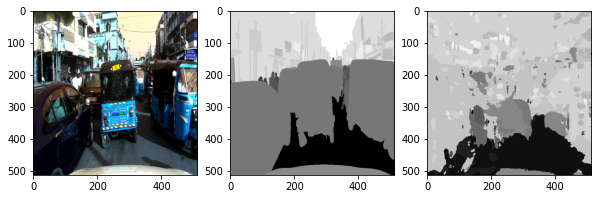

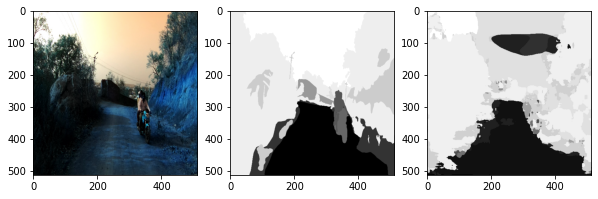

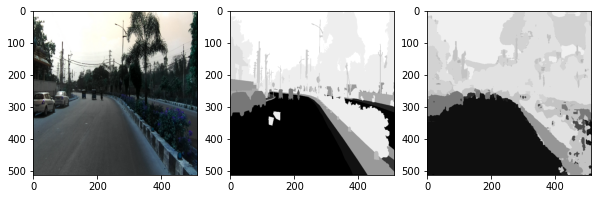

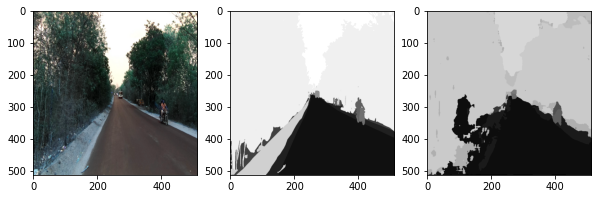

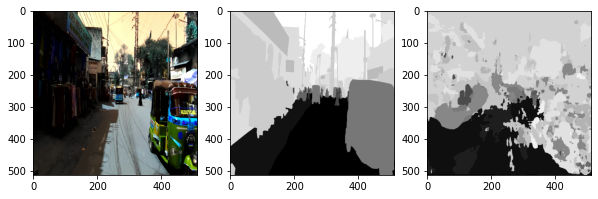

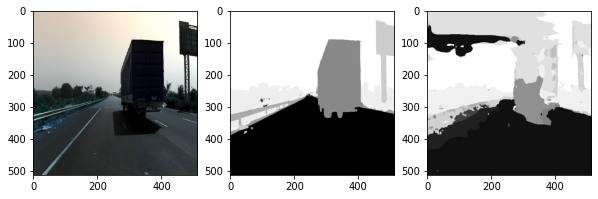

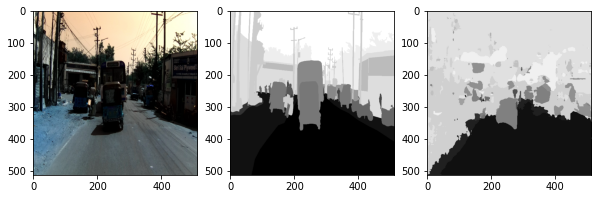

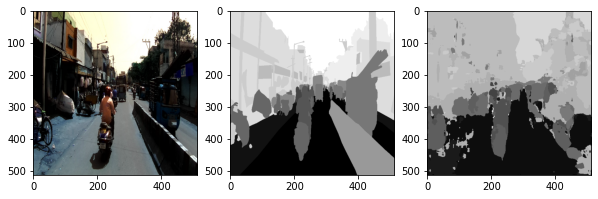

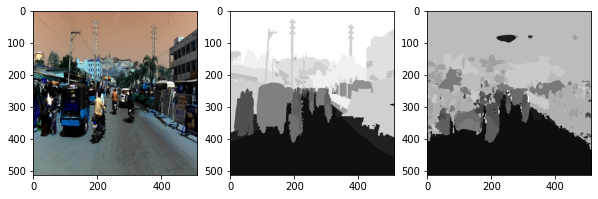

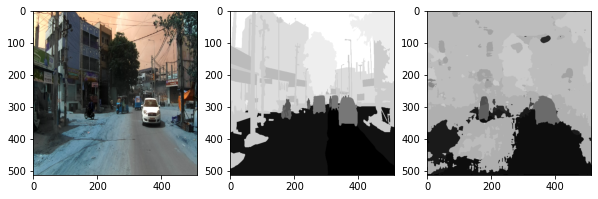

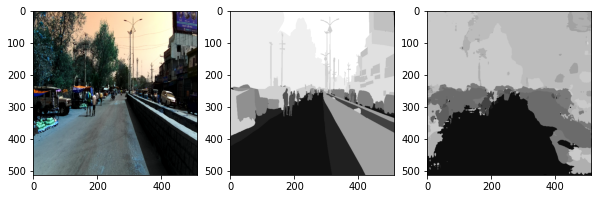

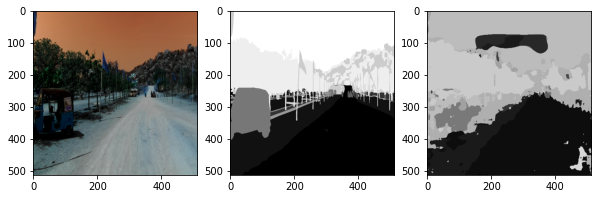

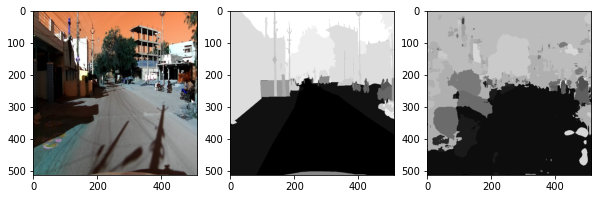

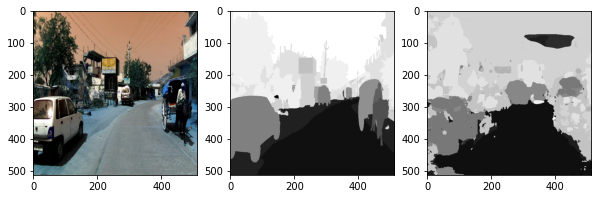

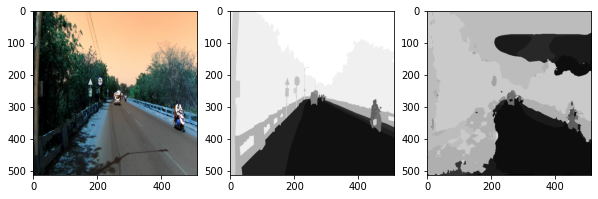

In [ ]:
for i in range(20):
    
    #original image  
    image = cv2.imread(sample_image[i], cv2.IMREAD_UNCHANGED) # same sample_image as in UNET
    image = cv2.resize(image, (512,512),interpolation = cv2.INTER_NEAREST) 
    
    #predicted segmentation mask
    predicted = model_2.predict(image[np.newaxis,:,:,:])
    predicted = tf.argmax(predicted, axis=-1)

    #original segmentation map
    image_mask = cv2.imread(sample_mask[i] , cv2.IMREAD_UNCHANGED) # same sample_mask as in UNET
    image_mask = cv2.resize(image_mask, (512,512))

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask,cmap='gray')
    plt.subplot(133)
    plt.imshow(predicted[0,:,:], cmap='gray')
    
    plt.show()


In [ ]:
%tensorboard --logdir logs/fit

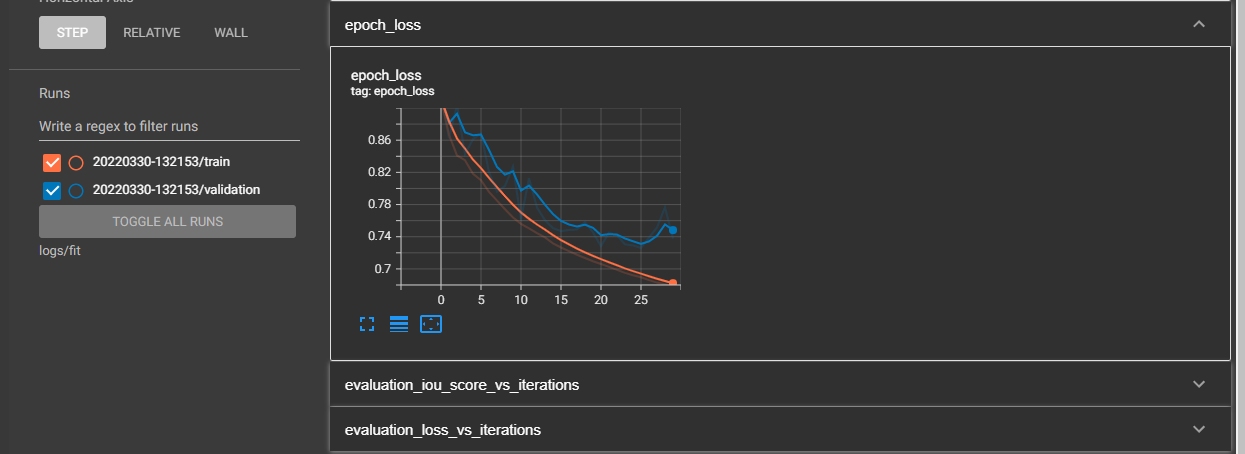

### Things to keep in mind

* You need to train  above built model and plot the train and test losses.
* Make sure there is no overfitting, you are free play with the identity blocks in C1, C2, C3, C4
* before we apply the final sigmoid activation, you can add more conv layers or BN or dropouts etc
* you are free to use any other optimizer or learning rate or weights init or regularizations

In [6]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Best IOC Score", "Best Dics Loss"]
x.add_row(["UNET", round(best_ioc_score_m1,2),round(best_dice_loss_m1,2)])
x.add_row(["CANet", round(best_ioc_score_m2,2),round(best_dice_loss_m2,2)])


print(x)

+-------+----------------+----------------+
| Model | Best IOC Score | Best Dics Loss |
+-------+----------------+----------------+
|  UNET |      0.5       |      0.47      |
| CANet |      0.4       |      0.73      |
+-------+----------------+----------------+


<pre>
<h2> Observations: </h2>

- We used two deep learning models in this assignment on image segmentation: UNET and CANet.

- An equal number of Images and JSON files were provided in the dataset, and segmentation masks were created according     to the information in the JSON files.


- From there, the UNET model was imported from the 'segmentation models' package and a transfer learning model was      created with Resnet34 as the backbone and encoder_weights as 'imagenet'. This model is given the input shape of        (512,512,3) and receives the output shape of (512,512,21).

- In the UNET model, all the images and masks were read and converted to tensors by using 'imageCV', before four        techniques of image augmentation were applied by using the 'imageaug' module. 
The model was evaluated using the IOC score and dice loss.

- We generated 20 segmentation masks using the model and plotted them, and the predicted masks (from the JSON files)    were similar to the one created using the JSON files.

- A CANET model was then implemented from scratch, with inputs and outputs identical to the UNET model

- Compared with the CANet model, the UNET model provided a better IOC score, and the predicted masks by the UNET model  were more similar to the masks generated using JSON files than the masks created by the CANet model.
</pre>